# Eight Schools - A Stan/Edward Comparison

In this tutorial we fit the 8 schools model to data made famous by __[Stan](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)__,  __[Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/)__ and first appearing in __[Rubin (1981) - (paywalled)](http://journals.sagepub.com/doi/abs/10.3102/10769986006004377)__.  The tutorial will be particularly suited to Stan users who are familiar with hierachichal models that would like to start using Edward.


In this example we introduce a slightly modified 8 Schools example and we compare Stan using the No-U-Turn sampler (NUTS) and Edward using Automatic Differential Variational Bayes (ADVI/KLQP) and Hamiltonian Monte Carlo (HMC).  Both the Stan and Edward code are included in this tutorial and you may choose to install __[pystan](http://pystan.readthedocs.io/en/latest/getting_started.html)__ or __[rstan](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)__ to run the Stan portions of code.  Comparison of Stan and Edward implementations can be a good way to check the algorithm and model is correct.  As we use our own Stan implementation of 8 schools our results will differ slightly with the improper priors used in the Stan __[getting started](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)__ and the Normal/Cauchy priors used in __[Diagnosing Biased Inference with Divergences](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html)__.  

We use the non-centred parameterisation as advocated in __[Diagnosing Biased Inference with Divergences](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html)__ - which is highly recommended reading, just note all three models use slightly different priors when comparing results.

In the centred (and simplified) form eight schools is a hierarchichal model:

$\mu \sim \mathcal{N}(0,10)$

$\log \tau \sim \mathcal{N}(5,1)$

$\theta \sim \mathcal{N}(\mu, (e^{ \log \tau})^2)$

$y_j \sim \mathcal{N}(\theta, \sigma^2_j)$

where $j \in [1..8]$ and $\{ y_j, \sigma_j \}$ are observed.

It may be easier to think of $\tau$ as the root variance, which we give a log normal prior to.



The Non-centred model is equivelent and more suitable for inference and takes the following form:

$\mu \sim \mathcal{N}(0,10)$

$\log \tau \sim \mathcal{N}(5,1)$

$\theta' \sim \mathcal{N}(0,1)$

$y_j \sim \mathcal{N}(\mu + (e^{ \log \tau}) \theta', \sigma_j^2)$

# Stan Model Definition

The Stan implementation of this non-centred model is:


In [1]:
eight_schools_stan = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real logtau;
  real theta_tilde[J];
}

model {
  mu ~ normal(0, 10);
  logtau ~ normal(5, 1);
  theta_tilde ~ normal(0, 1);
  for (j in 1:J) {
      y[j] ~ normal(mu + exp(logtau) * theta_tilde[j], sigma[j]);
  }
}
"""





The Stan code quite closely follows the model definition.  Note that putting the Stan code in a string like this is convenient for this tutorial, but usually you should instead put the code in a separate file.

We will also define the data:

In [2]:
import numpy as np
J = 8
data_y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
data_sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])

# Stan NUTS inference 

This allows us to run the Stan code (make sure pystan is installed for this step).

In [ ]:
import pystan
standata = dict(J=J, y=data_y, sigma=data_sigma)

fit = pystan.stan(model_code=eight_schools_stan, 
                  data=standata, iter=100000)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d66c37004ddc3041422a88e70f9afbc NOW.


The inferred parameter theta_tilda or $\theta'$ is a transform, we might prefer to convert this back to the more intepretable theta by posthoc processing of the samples or by including a generated quantities block in the Stan code.  In this case the required postprocessing is quite simple.

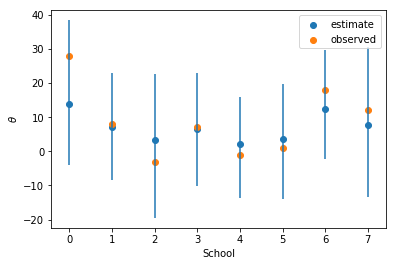

In [19]:
import matplotlib.pyplot as plt

s = fit.extract()
theta = np.tile(s['mu'], [8, 1]) \
    + np.tile(np.exp(s['logtau']), [8, 1]) * s['theta_tilde'].T

theta_low = np.array([np.percentile(theta[ii, ], 2.5) for ii in range(8)])
theta_hi = np.array([np.percentile(theta[ii, ], 97.5) for ii in range(8)])
theta_med = np.array([np.percentile(theta[ii, ], 50) for ii in range(8)])


fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(range(8), theta_med)
ax.scatter(range(8), data_y)
ax.errorbar(range(8), theta_med,
            yerr=[theta_med - theta_low, theta_hi - theta_med], fmt='none')
plt.xlabel('School')
plt.ylabel('$\\theta$')
plt.legend(('estimate', 'observed'))
plt.show()

The pooling for this model is determined by the prior on the root variance parameter $\tau$.  By varying the prior on $\tau$ the model can estimate $\theta_j$ as being close to $y_j$ or all values of $\theta_j$ being both similar to each other and close to $\bar{y}$.  Here we observe a compromise between these two extreme positions, the estimate $\theta_j$ is between to $\bar{y}$ and $y_j$. 

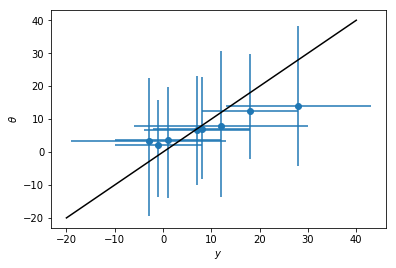

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
plt.plot([-20, 40], [-20, 40], 'k')
ax.scatter(data_y, theta_med)
ax.errorbar(data_y, theta_med,
            yerr=[theta_med - theta_low, theta_hi - theta_med],
            xerr=data_sigma, fmt='none')
plt.xlabel('$y$')
plt.ylabel('$\\theta$')
plt.show()

The above plot shows how the observed $y_j$ corresponds to it's estimated value $\theta_j$, without pooling $\theta_j$ would follow $y_j$ (i.e. the estimate would fall on the black line), with full pooling $\theta_j$ would equal $\bar{y}$ we again see we have a compromise here.

In [21]:
s = fit.extract()
stan_theta_tilde_low = np.array([np.percentile(s['theta_tilde'][:, ii], 2.5)
                                for ii in range(8)])
stan_theta_tilde_hi = np.array([np.percentile(s['theta_tilde'][:, ii], 97.5)
                                for ii in range(8)])
stan_theta_tilde_med = np.array([np.percentile(s['theta_tilde'][:, ii], 50)
                                for ii in range(8)])

# Edward Model Definition

Let's now define the same model using Edward:

In [15]:
import edward as ed
import tensorflow as tf
from edward.models import Normal, Empirical

mu = Normal([0.], [1.])
logtau = Normal([5.], [1.])
theta_tilde = Normal(tf.zeros(J), tf.ones(J))
sigma = tf.placeholder(tf.float32, J)
y = Normal(mu + tf.exp(logtau) * theta_tilde, sigma * tf.ones([J]))



Similarly we define the data

In [16]:
data = {y: data_y, sigma: data_sigma}

# Edward Automatic Differentiation Variational Bayes inference

We now use ed.KLqp to perform ADVI.  To do this we define the variational approximation family (as Gaussian) and then optimize the lower bound using Edwards ed.KLqp function.

In [17]:
with tf.variable_scope('q_logtau'):
    q_logtau = Normal(tf.get_variable('loc', [1]),
                      tf.nn.softplus(tf.get_variable('scale', [1])))

with tf.variable_scope('q_mu'):        
    q_mu = Normal(tf.get_variable('loc', [1]),
                  tf.nn.softplus(tf.get_variable('scale', [1])))

with tf.variable_scope('q_theta_tilde'):
    q_theta_tilde = Normal(tf.get_variable('loc', [J]),
                           tf.nn.softplus(tf.get_variable('scale', [J])))


inference = ed.KLqp({logtau: q_logtau, mu: q_mu, theta_tilde: q_theta_tilde},
                    data=data)
inference.run(n_samples=15, n_iter=60000)


60000/60000 [100%] ██████████████████████████████ Elapsed: 158s | Loss: 35.756


In [25]:
klqp_theta_tilde_med = np.array(q_theta_tilde.mean().eval())
klqp_theta_tilde_hi =  np.array(q_theta_tilde.mean().eval() \
                                + 1.96 * q_theta_tilde.stddev().eval())
klqp_theta_tilde_low = np.array(q_theta_tilde.mean().eval() \
                                - 1.96 * q_theta_tilde.stddev().eval())

print("====    ed.KLqp inference ====")
print("E[mu] = %f" % (q_mu.mean().eval()))
print("E[logtau] = %f" % (q_logtau.mean().eval()))
print("E[theta_tilde]=")
print((q_theta_tilde.mean().eval()))
print("====  end ed.KLqp inference ====")

====    ed.KLqp inference ====
E[mu] = -1.126185
E[logtau] = 1.412228
E[theta_tilde]=
[-0.52939075 -0.41602248 -0.28504208  0.29774344  0.39141911 -0.06167227
  0.29494578  0.48202866]
====  end ed.KLqp inference ====


# Edward HMC inference

We now fit the same Edward model using HMC which is similar to Stan's NUTS algorithm but has more algorithm parameters to tune (although here we just use Edward's defaults).

This is similar to ADVI except that the approximating family is Edward's Empirical type and the sampling is performed using Edwards ed.HMC function.  Note: unlike Stan's self tuning NUTS algoirthm HMC does need to be tuned for a particular problem.  Here we find the defaults work acceptably, but this cannot be assumed in general.

In [24]:
S = 400000
burn = S // 2
hq_logtau = Empirical(tf.Variable(tf.zeros([S, 1])))
hq_mu = Empirical(tf.Variable(tf.zeros([S, 1])))
hq_theta_tilde = Empirical(tf.Variable(tf.zeros([S, J])))

inference = ed.HMC({logtau: hq_logtau, mu: hq_mu,
                    theta_tilde: hq_theta_tilde}, data=data)
inference.run()

400000/400000 [100%] ██████████████████████████████ Elapsed: 399s | Acceptance Rate: 0.910


In [26]:
hmc_theta_tilde_low = np.array([np.percentile(
    hq_theta_tilde.params.eval()[burn:, ii], 2.5) for ii in range(8)])
hmc_theta_tilde_hi = np.array([np.percentile(
    hq_theta_tilde.params.eval()[burn:, ii], 97.5) for ii in range(8)])
hmc_theta_tilde_med = np.array([np.percentile(
    hq_theta_tilde.params.eval()[burn:, ii], 50) for ii in range(8)])

print("====    ed.HMC inference ====")
print("E[mu] = %f" % (hq_mu.params.eval()[burn:].mean()))
print("E[logtau] = %f" % (hq_logtau.params.eval()[burn:].mean()))
print("E[theta_tilde]=")
print(hq_theta_tilde.params.eval()[burn:, ].mean(0))
print("====  end ed.HMC inference ====")

====    ed.HMC inference ====
E[mu] = 0.211050
E[logtau] = 2.528206
E[theta_tilde]=
[ 0.83307999  0.35065821 -0.09229225  0.28517568 -0.06072126  0.03697859
  0.79269022  0.2940602 ]
====  end ed.HMC inference ====


# Comparison of the approximate posteriors for $\theta'$

We can graphically show the the three methods have very similar $95\%$ intervals for $\theta'$:

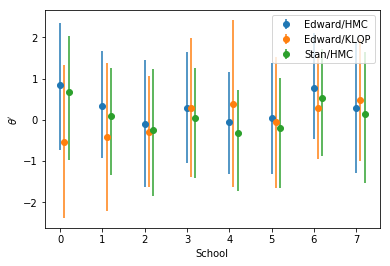

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, sharex=True)

ax.errorbar(np.array(range(8)), hmc_theta_tilde_med,
            yerr=[hmc_theta_tilde_med - hmc_theta_tilde_low,
                  hmc_theta_tilde_hi - hmc_theta_tilde_med], fmt='o')
ax.errorbar(np.array(range(8)) + 0.1, klqp_theta_tilde_med,
            yerr=[klqp_theta_tilde_med - klqp_theta_tilde_low,
                  klqp_theta_tilde_hi - klqp_theta_tilde_med], fmt='o')
ax.errorbar(np.array(range(8)) + 0.2, stan_theta_tilde_med,
            yerr=[stan_theta_tilde_med - stan_theta_tilde_low,
                  stan_theta_tilde_hi - hmc_theta_tilde_med], fmt='o')
ax.legend(('Edward/HMC', 'Edward/KLQP', 'Stan/HMC'))
plt.ylabel('$\\theta\'$')
plt.xlabel('School')
plt.show()
